The following notebook attempts towards creating a mood based playlist recommender system for spotify. 
I used the spotipy library in python to import data from the spotifyAPI in order to classify
music into 3 different moods - Happy, Angry, Sad
For my training set, I chose 3 playlists that contained music belonging to one of
the 3 categories, and imported them into my colab workspace using spotipy’s
audio_features. I converted each playlist into a pandas dataframe and
concatenated one after the other.
I utilized HuggingFace's BARTtokenizer to work with the dataset since it easily understands and learns language. 


In [ ]:
pip install spotipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.3/240.3 kB 8.3 MB/s eta 0:00:00


In [ ]:
import os
import os.path
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyOAuth
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
import time
import numpy as np

In [ ]:
c_id = os.environ['SPOTIPY_CLIENT_ID'] = '069d1d5b8c334a78a6eb016691b0a1e9'
c_sec = os.environ['SPOTIPY_CLIENT_SECRET'] = 'c8553b3ec30b4dbf92aac8f8e76b3f63'

In [ ]:
sp_scope = "user-library-read user-library-modify"
sp_credentials = SpotifyClientCredentials(client_id=c_id, client_secret=c_sec)

client_credentials_manager = SpotifyClientCredentials(client_id = c_id, client_secret = c_sec)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

sp_oauth = SpotifyOAuth(
    username="Adyantchawla",
    scope=sp_scope,
    client_id=c_id,
        client_secret=c_sec,
    redirect_uri="https://localhost:8888/callback",
    open_browser=False
)

In [ ]:
# my spotify username and playlist ids
# on playlist page, click on "..." -> then on "Share" -> then "Copy Spotify URI"
def getTrackIDs(user, playlist_id):
    ids = []
    playlist = sp.user_playlist(user, playlist_id)
    for item in playlist['tracks']['items']:
        track = item['track']
        ids.append(track['id'])
    return ids

In [ ]:
# Get spotify singular song data from these locations
# https://developer.spotify.com/documentation/web-api/reference/#/operations/get-track
# https://developer.spotify.com/documentation/web-api/reference/#/operations/get-audio-features
def getTrackFeatures(id):
    meta = sp.track(id)
    features = sp.audio_features(id)

    # meta
    name = meta['name']
    album = meta['album']['name']
    artist = meta['album']['artists'][0]['name']
    release_date = meta['album']['release_date']
    length = meta['duration_ms']
    popularity = meta['popularity']

    # features
    acousticness = features[0]['acousticness']
    danceability = features[0]['danceability']
    energy = features[0]['energy']
    instrumentalness = features[0]['instrumentalness']
    liveness = features[0]['liveness']
    loudness = features[0]['loudness']
    speechiness = features[0]['speechiness']
    tempo = features[0]['tempo']
    valence = features[0]['valence']
    time_signature = features[0]['time_signature']
    key = features[0]['key']
    mode = features[0]['mode']
    uri = features[0]['uri']

    track = [name, album, artist, release_date,
             length, popularity, acousticness,
             danceability, energy, instrumentalness,
             liveness, loudness, speechiness, tempo,
             valence, time_signature,
             key, mode, uri]
    return track

In [ ]:
# loop over track ids to get all songs in playlist
def loop_playist(playlist_ids):
    tracks = []
    for i in range(len(playlist_ids)):
        time.sleep(.2)
        track = getTrackFeatures(playlist_ids[i])
        tracks.append(track)
    return tracks

In [ ]:
# turn data into dataframe
def get_spotify_df(tracks, year):
    df = pd.DataFrame(tracks, columns = ['name', 'album', 'artist', 'release_date',
                                         'length', 'popularity', 'acousticness', 'danceability',
                                         'energy', 'instrumentalness', 'liveness', 'loudness',
                                         'speechiness', 'tempo', 'valence', 'time_signature',
                                         'key', 'mode', 'uri'])
    return df

In [ ]:
def get_years(df):
    years = []
    for date in df['release_date'].values:
        if '-' in date:
            years.append(date.split('-')[0])
        else:
            years.append(date)
    df['release_year'] = years
    return df

In [ ]:
username = 'pranav_p'
play_link_test = 'https://open.spotify.com/playlist/7dJ7esbzPkfxMXAxO42s0N?si=7348633ca1184265'
happy = 'https://open.spotify.com/playlist/3YVyKaJWI4u3L612UkimdV?si=cd57a58cf3a54e94'
sad = 'https://open.spotify.com/playlist/30PVcG8uBzVwbPJyiQEIbl?si=af8eda7aa931401a'
angry = 'https://open.spotify.com/playlist/0a4Hr64HWlxekayZ8wnWqx?si=d24f07d30bc24ea8'

In [ ]:
id_test = getTrackIDs(username, play_link_test)
id_sad = getTrackIDs(username, sad)
id_angry = getTrackIDs(username, angry)
id_happy = getTrackIDs(username, happy)

In [ ]:
playloopid = loop_playist(id_test)
plid_sad = loop_playist(id_sad)
plid_angry = loop_playist(id_angry)
plid_happy = loop_playist(id_happy)

In [ ]:
df_test = get_spotify_df(playloopid, 1)
df_sad = get_spotify_df(plid_sad, 1)
df_happy = get_spotify_df(plid_happy, 1)
df_angry = get_spotify_df(plid_angry, 1)

In [ ]:
df_test = get_years(df_test)
df_sad = get_years(df_sad)
df_happy = get_years(df_happy)
df_angry = get_years(df_angry)

In [ ]:
df_angry

In [ ]:
import numpy as np
def transform_df_to_words(df):
  df['valence'] = np.where(df['valence'] < 0.5, 'this song does not have high positiveness', 'this song does have high positiveness')
  df['danceability'] = np.where(df['danceability'] < 0.5, 'this song is not easy to dance to', 'this song is easy to dance to')
  df['tempo'] = np.where(df['tempo'] < 125, 'this song has slow pace music', 'this song has fast pace music')
  df['instrumentalness'] = np.where(df['instrumentalness'] < 0.5, 'this song is more vocal and less instrumental', 'this song is more instrumental and less vocal')
  df['energy'] = np.where(df['energy'] < 0.6, 'this song has low to moderate energy levels', 'this song has high energy levels')
  df['loudness'] = np.where(df['loudness'] < -6.8575, 'this is a loud song', 'this is not a very loud song')
  df['acousticness'] = np.where(df['acousticness'] < 0.5, 'this song is less likely to be acoustic', 'this song is more likely to be acoustic')
  df['speechiness'] = np.where(df['speechiness'] < 0.33, 'this song most likely does not have speech',
                                np.where(df['speechiness'] < 0.66, 'this song most likely has music and speech',
                                        'this song most likely has a lot of speech'))
  df['liveness'] = np.where(df['liveness'] > 0.8, 'This song was most likely performed live',
                            np.where(df['liveness'] >= 0.5, 'This song may have been performed live',
                                        'This song most likely has not been performed live'))
  df = df.drop(columns=['length', 'popularity', 'time_signature', 'key', 'mode', 'uri' ])
  return df

In [ ]:
df_test = transform_df_to_words(df_test)

In [ ]:
df_sad = transform_df_to_words(df_sad)


In [ ]:
df_angry = transform_df_to_words(df_angry)

In [ ]:
df_happy = transform_df_to_words(df_happy)

In [ ]:
df_sad = df_sad.iloc[:-8]

In [ ]:
df_sad

In [ ]:
df_sad['mood'] = 'sad'
df_happy['mood'] = 'happy'
df_angry['mood'] = 'angry'

<ipython-input-30-335190902d95>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sad['mood'] = 'sad'


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 53.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 112.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 29.3 MB/s eta 0:00:00


In [ ]:
df_angry

In [ ]:
correct = pd.concat([df_sad, df_happy], ignore_index=True)

In [ ]:
final_train = pd.concat([correct, df_angry], ignore_index=True)

In [ ]:
final_train

In [ ]:
df_test.to_csv('test.csv', index = False)

In [ ]:
df_test = pd.read_csv('testing_data.csv')

In [ ]:
df_test

Implementing Bart

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 88.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 64.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 27.1 MB/s eta 0:00:00


In [ ]:
import torch
import pandas as pd
from transformers import BartTokenizer, BartForSequenceClassification

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Load BART tokenizer and model
num_type = final_train['mood'].nunique()
tokenizer = BartTokenizer.from_pretrained('facebook/bart-large')
model = BartForSequenceClassification.from_pretrained('facebook/bart-large', num_labels=num_type)
model_sad = model.to(device)


Some weights of BartForSequenceClassification were not initialized from the model checkpoint at facebook/bart-large and are newly initialized: ['classification_head.out_proj.bias', 'classification_head.dense.weight', 'classification_head.dense.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Convert country column to one-hot encoding
one_hot_train = pd.get_dummies(final_train['mood'])
one_hot_test = pd.get_dummies(df_test['mood'])

# Tokenize names and convert to PyTorch dataset
inputs_train = tokenizer(list(final_train['acousticness']), return_tensors='pt', padding=True)
labels_train = torch.tensor(one_hot_train.values, dtype=torch.float32)
dataset_train = torch.utils.data.TensorDataset(inputs_train['input_ids'], inputs_train['attention_mask'], labels_train)
inputs_test = tokenizer(list(df_test['acousticness']), return_tensors='pt', padding=True)
labels_test = torch.tensor(one_hot_test.values, dtype=torch.float32)
dataset_test = torch.utils.data.TensorDataset(inputs_test['input_ids'], inputs_test['attention_mask'], labels_test)


In [ ]:

# Define training parameters
epochs = 10
batch_size = 16
learning_rate = 2e-5

# Train model
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
data_loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
data_loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size)

print(f"\nTraining on {len(final_train)} examples\n")
print("Num. Parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))

for epoch in range(epochs):
    # Compute average loss after 100 steps
    avg_loss = 0
    for step, batch in enumerate(data_loader_train):
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        avg_loss += loss.item()
        if step % 100 == 0:
            print(f"Step {step}/{len(data_loader_train)} Loss {loss} Avg Train Loss {avg_loss / (step + 1)}")
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss = avg_loss / len(data_loader_train)
    # Print loss after every epoch
    print(f"Epoch {epoch+1} Test Loss {loss}")
    # Compute accuracy after every epoch
    correct = 0
    total = 0
    for step, batch in enumerate(data_loader_test):
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        predicted = torch.argmax(outputs[0], dim=1)
        total += labels.size(0)
        correct += (predicted == torch.argmax(labels, dim=1)).sum().item()
    print(f"Test Accuracy {100*correct/total}%\n")

# Save model
model.save_pretrained('fine-tuned-bart_countries')


Training on 84 examples

Num. Parameters: 407344131
Step 0/6 Loss 0.7842925786972046 Avg Train Loss 0.7842925786972046
Epoch 1 Test Loss 0.6579185624917349
Test Accuracy 36.0%

Step 0/6 Loss 0.5822798609733582 Avg Train Loss 0.5822798609733582
Epoch 2 Test Loss 0.6236592332522074
Test Accuracy 36.0%

Step 0/6 Loss 0.5787367224693298 Avg Train Loss 0.5787367224693298
Epoch 3 Test Loss 0.5988520284493765
Test Accuracy 36.0%

Step 0/6 Loss 0.5785210132598877 Avg Train Loss 0.5785210132598877
Epoch 4 Test Loss 0.5938141345977783
Test Accuracy 36.0%

Step 0/6 Loss 0.6231328248977661 Avg Train Loss 0.6231328248977661
Epoch 5 Test Loss 0.6104408701260885
Test Accuracy 36.0%

Step 0/6 Loss 0.6388164758682251 Avg Train Loss 0.6388164758682251
Epoch 6 Test Loss 0.6081972618897756
Test Accuracy 36.0%

Step 0/6 Loss 0.5646700263023376 Avg Train Loss 0.5646700263023376
Epoch 7 Test Loss 0.6129399339358012
Test Accuracy 36.0%

Step 0/6 Loss 0.5693923234939575 Avg Train Loss 0.5693923234939575
Epoch

In [ ]:
model.eval()
correct = 0
total = 0
for step, batch in enumerate(data_loader_test):
    input_ids, attention_mask, labels = batch
    input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
    outputs = model(input_ids, attention_mask=attention_mask)
    predicted = torch.argmax(outputs[0], dim=1)
    total += labels.size(0)
    correct += (predicted == torch.argmax(labels, dim=1)).sum().item()

print(f"Accuracy {correct/total}")

Accuracy 0.36


tensor([[21.,  0.,  6.],
        [20.,  0.,  9.],
        [29.,  0., 15.]])


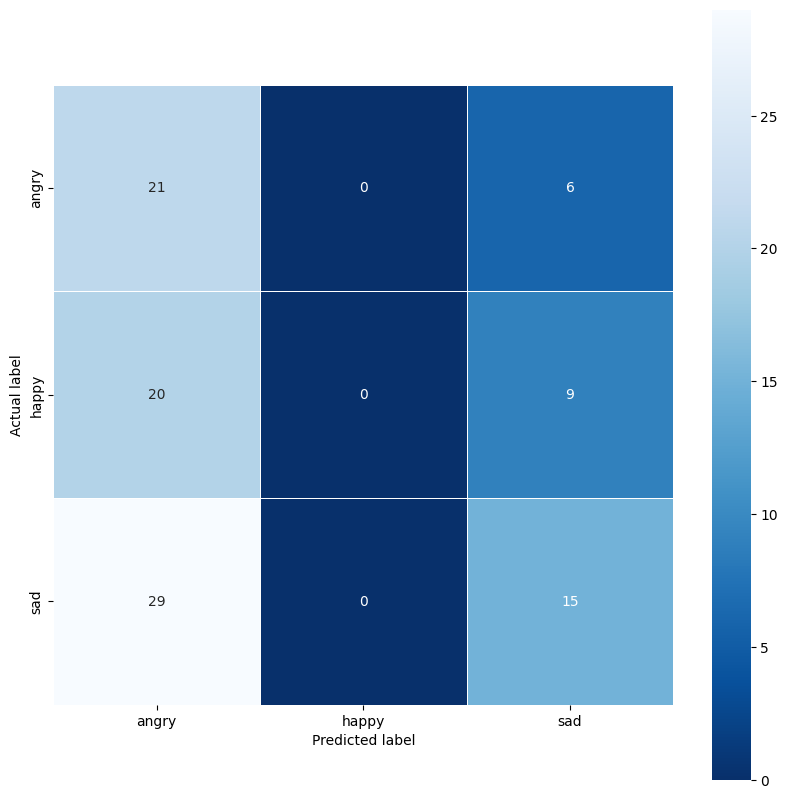

In [ ]:
# Make confusion matrix
confusion_matrix = torch.zeros(len(one_hot_test.columns), len(one_hot_test.columns))
for step, batch in enumerate(data_loader_test):
    input_ids, attention_mask, labels = batch
    input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
    outputs = model(input_ids, attention_mask=attention_mask)
    predicted = torch.argmax(outputs[0], dim=1)
    for i in range(len(predicted)):
        confusion_matrix[torch.argmax(labels[i])][predicted[i]] += 1

print(confusion_matrix)

# Plot confusion matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
plt.figure(figsize=(10,10))
sns.heatmap(confusion_matrix, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r', xticklabels=one_hot_train.columns, yticklabels=one_hot_train.columns)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()
